# Movie Recommendation Engine

### Sylvia Lee
### Unsupervised Learning Capstone Project

# Purpose of Study

Build a content-based recommendation engine that helps Netflix identify similar movies to users based on movie characteristics. 

# Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

#NLP
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

#dimensionality reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

#set display 
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 1000)
pd.options.display.max_columns = 1000
sns.set()

#set random seed 
from numpy.random import seed
seed(1)

# The Data

+ Contains metadata for 4,803 movies listed in TMDb movie database
+ Consists of movies released on or before July 2017
+ Information includes cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDb vote counts and vote averages
+ Downloaded from [kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv)

In [2]:
#read in data files 
credits = pd.read_csv('tmdb-movie-metadata/tmdb_5000_credits.csv')
meta = pd.read_csv('tmdb-movie-metadata/tmdb_5000_movies.csv')

The 'credits' dataset contains following fields:
+ movie_id: unique identifier for each movie 
+ cast: character and cast names 
+ crew: name of Director, Editor, Composer, Writer etc

The 'meta' dataset contains following fields:
+ budget: movie budget 
+ genre: genres of movie, e.g., Action, Adventure, Fantasy and Sciene Fiction
+ homepage: the link to the movie's home page
+ id: the same id as the movie_id in the 'credits' dataset 
+ keywords: the keywords or tags related to the movie
+ original language: the language in which the movie was made 
+ orignal_title: the title of the movie before translation 
+ overview: a brief description of the movie
+ popularity: a score quantifying movie popularity
+ production_companies: the production house of the movie
+ production_countries: the country where the movie was produced 
+ release_date: when the movie was released
+ revenue: the worldwide revenue generated by the movie
+ runtime: movie length in minutes 
+ status: Released, Rumored, Post-Production
+ tagline: the movies's tagline
+ title: title of the movie
+ vote_average: average rating of the movie
+ vote_count: total count of ratings of the movie 

In [3]:
#combine two datasets
credits.columns = ['id', 'title', 'cast', 'crew']
movies_df = pd.merge(meta, credits, on='id')

In [311]:
movies_df.head(1)

budget  \
id                 
19995  237000000   

                                                                                                                                       genres  \
id                                                                                                                                              
19995  [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]   

                          homepage  \
id                                   
19995  http://www.avatarmovie.com/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              keywords  \
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
19995  [{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]   

      original_language original_title  \
id                                       
19995                en         Avatar   

                                                                                                                                                                              overview  \
id                                                                                                                                                                                       
19995  In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.   

       popularity  \
id                  
19995  150.437577   

                                                                                                                                                                                              production_companies  \
id                                                                                                                                                                                                 

In [4]:
movies_df.set_index('id', inplace=True)

In [6]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 19995 to 25975
Data columns (total 22 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title_x                 4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
title_y                 4803 non-

# Data Cleaning

For each movie, 
+ Extract year from releasing date
+ Extract list of genres
+ Extract keywords
+ Extract two leading cast 
+ Extract director from 'crew' column

In [4]:
#a copy of original data
movies = movies_df.copy()
#set title as index
movies.set_index('original_title', inplace=True)

In [5]:
#extract year and month from the datetime
import datetime
movies['year'] = pd.DatetimeIndex(movies['release_date']).year
movies = movies.drop(['release_date'], axis=1)

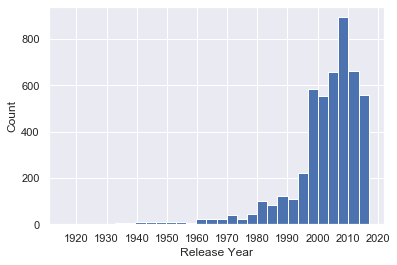

In [6]:
movies['year'].hist(bins=30)
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xticks(range(1920,2021,10))
plt.show()

In [7]:
#parse string list features into python objects

from ast import literal_eval

feats = ['genres', 'keywords', 'cast', 'crew']

for i in feats:
    
    movies[i] = movies[i].apply(literal_eval)

In [8]:
#extract list of genres

def names(x):
    
    names = [i['name'] for i in x]
    
    return (names)

movies['genres'] = movies['genres'].apply(names)

In [9]:
#extract keywords 

def keywords(x):
    
    words = [i['name'] for i in x]
    
    return (words)

movies['keywords'] = movies['keywords'].apply(keywords)

In [10]:
#extract leading cast

def cast_list(x):
    
    cast = [i['name'] for i in x]
    
    if len(cast) > 2:
        
        cast = cast[:2]
        
    return (cast)

movies['cast'] = movies['cast'].apply(cast_list)

In [11]:
#extract director 

def director(x):
    
    for i in x:
        
        if i['job'] == 'Director':
            
            return i['name']
        
    return np.nan

movies['director'] = movies['crew'].apply(director)

movies = movies.drop('crew', axis=1)

## Missing Data

In [12]:
#check missing
total_missing = movies.isnull().sum().sort_values(ascending=False)
percent_missing = (movies.isnull().sum()/movies.isnull().count()*100).sort_values(ascending=False)

missing = pd.concat([total_missing, percent_missing], axis=1, keys=['Total_missing', 'Percent_missing'])

In [13]:
#vars with missing data
missing[missing['Percent_missing']>0]

Total_missing  Percent_missing
homepage           3091        64.355611
tagline             844        17.572351
director             30         0.624610
overview              3         0.062461
runtime               2         0.041641
year                  1         0.020820

In [14]:
movies['status'].value_counts()

Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64

Homepage has 64% missing data and and Tagline has 18% missing data, so they are not included in the analysis. Minimal missing values in Director, Overview, Runtime and Release Year are dropped. 

In [15]:
#only keep movies with 'Released' status

movies0 = movies[movies['status']=='Released']

#keep movie characteristics in the analysis

movies0 = movies0 [['genres', 'keywords', 'overview', 'popularity', 
                    'year', 'runtime', 'vote_average', 'vote_count', 'cast', 'director'
                  ]]

#drop NaNs for Director, Overview, Runtime and Release Year
movies0 = movies0.dropna()

movies0.head(1)

genres  \
original_title                                                  
Avatar          [Action, Adventure, Fantasy, Science Fiction]   

                                                                                                                                                                                                                                keywords  \
original_title                                                                                                                                                                                                                             
Avatar          [culture clash, future, space war, space colony, society, space travel, futuristic, romance, space, alien, tribe, alien planet, cgi, marine, soldier, battle, love affair, anti war, power relations, mind and soul, 3d]   

                                                                                                                                                                                       overview  \
original_title                                                                                                                                                                                    
Avatar          In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.   

                popularity    year  runtime  vote_average  vote_count  \
original_title                                                          
Avatar          150.437577  2009.0    162.0           7.2       11800   

                                          cast       director  
original_title                                                 
Avatar          [Sam Worthington, Zoe Saldana]  James Cameron

In [25]:
movies0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4764 entries, Avatar to My Date with Drew
Data columns (total 10 columns):
genres          4764 non-null object
keywords        4764 non-null object
overview        4764 non-null object
popularity      4764 non-null float64
year            4764 non-null float64
runtime         4764 non-null float64
vote_average    4764 non-null float64
vote_count      4764 non-null int64
cast            4764 non-null object
director        4764 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 409.4+ KB


## Outlier

In [16]:
num = movies0.select_dtypes(['int64', 'float64']).columns

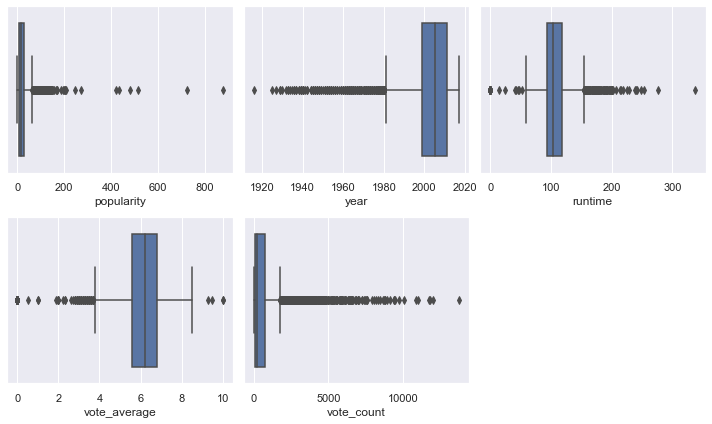

In [17]:
plt.figure(figsize=(10,6))
for i in range(len(num)):
    plt.subplot(2,3,i+1)
    sns.boxplot(movies0[num[i]])
plt.tight_layout()
plt.show()

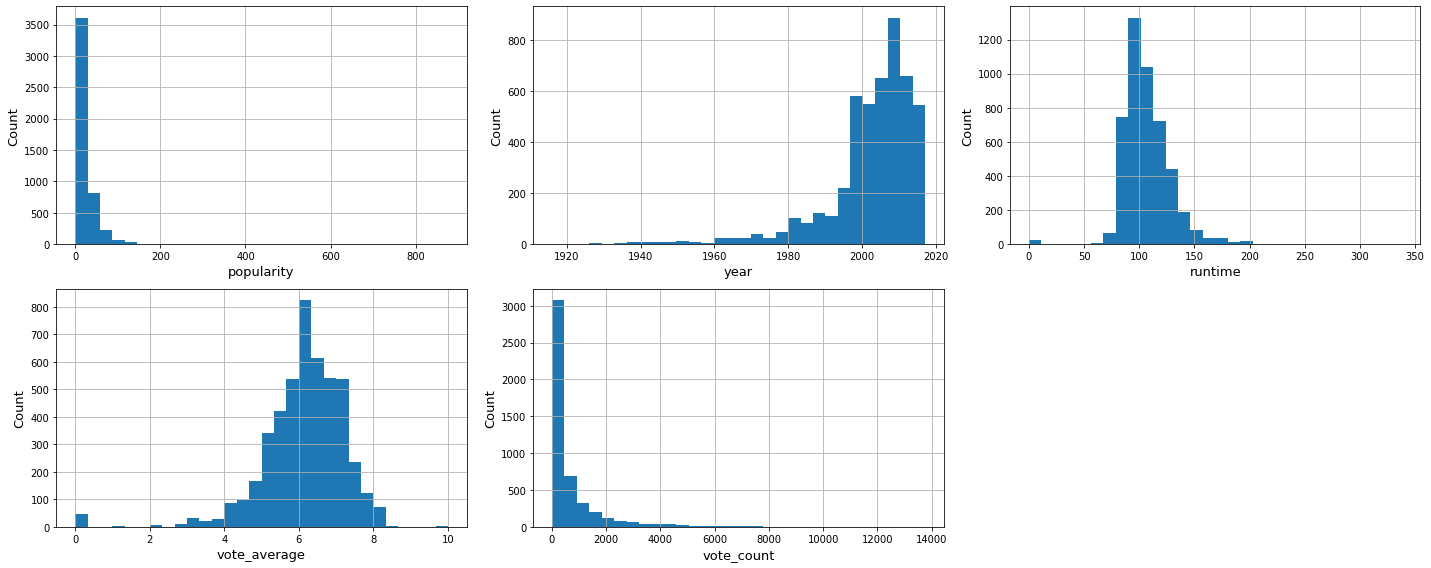

In [28]:
plt.figure(figsize=(20,8))
for i in range(len(num)):
    plt.subplot(2,3,i+1)
    movies0[num[i]].hist(bins=30)
    plt.xlabel(num[i], fontsize=13)
    plt.ylabel('Count', fontsize=13)
plt.tight_layout()
plt.show()

In [29]:
#lastest movie was released in 2017
movies0['year'].value_counts().sort_index(ascending=False).head()

2017.0      1
2016.0    104
2015.0    206
2014.0    233
2013.0    230
Name: year, dtype: int64

In [15]:
movies0['runtime'].value_counts().sort_index().head()

0.0     23
14.0     1
25.0     1
41.0     1
42.0     1
Name: runtime, dtype: int64

Note that there are 23 movies having runtime of zero. I exclude them from the analysis. 

In [18]:
#remove 23 movies with length of 0
movies1 = movies0[movies0['runtime'] > 0]

In [17]:
#vote_count and vote_average
movies1['vote_count'].value_counts().sort_index().head()

0    42
1    41
2    36
3    39
4    39
Name: vote_count, dtype: int64

In [18]:
movies1['vote_average'].value_counts().sort_index().head()

0.0    43
0.5     1
1.0     1
1.9     1
2.0     4
Name: vote_average, dtype: int64

In [19]:
movies1['vote_count'].describe()

count     4741.000000
mean       699.195739
std       1240.118360
min          0.000000
25%         58.000000
50%        242.000000
75%        750.000000
max      13752.000000
Name: vote_count, dtype: float64

In [19]:
#smaller version of dataframe for display purpose
sm1 = movies1.drop(['genres', 'keywords', 'overview'], axis=1)

In [20]:
#top votes 
sm1.sort_values(['vote_count'], ascending=False).head(10)

popularity    year  runtime  vote_average  \
original_title                                                       
Inception                167.583710  2010.0    148.0           8.1   
The Dark Knight          187.322927  2008.0    152.0           8.2   
Avatar                   150.437577  2009.0    162.0           7.2   
The Avengers             144.448633  2012.0    143.0           7.4   
Deadpool                 514.569956  2016.0    108.0           7.4   
Interstellar             724.247784  2014.0    169.0           8.1   
Django Unchained          82.121691  2012.0    165.0           7.8   
Guardians of the Galaxy  481.098624  2014.0    121.0           7.9   
The Hunger Games          68.550698  2012.0    142.0           6.9   
Mad Max: Fury Road       434.278564  2015.0    120.0           7.2   

                         vote_count  \
original_title                        
Inception                     13752   
The Dark Knight               12002   
Avatar                        11800   
The Avengers                  11776   
Deadpool                      10995   
Interstellar                  10867   
Django Unchained              10099   
Guardians of the Galaxy        9742   
The Hunger Games               9455   
Mad Max: Fury Road             9427   

                                                              cast  \
original_title                                                       
Inception                [Leonardo DiCaprio, Joseph Gordon-Levitt]   
The Dark Knight                     [Christian Bale, Heath Ledger]   
Avatar                              [Sam Worthington, Zoe Saldana]   
The Avengers                      [Robert Downey Jr., Chris Evans]   
Deadpool                          [Ryan Reynolds, Morena Baccarin]   
Interstellar               [Matthew McConaughey, Jessica Chastain]   
Django Unchained                     [Jamie Foxx, Christoph Waltz]   
Guardians of the Galaxy                 [Chris Pratt, Zoe Saldana]   
The Hunger Games              [Jennifer Lawrence, Josh Hutcherson]   
Mad Max: Fury Road                    [Tom Hardy, Charlize Theron]   

                                  director  
original_title                              
Inception                Christopher Nolan  
The Dark Knight          Christopher Nolan  
Avatar                       James Cameron  
The Avengers                   Joss Whedon  
Deadpool                        Tim Miller  
Interstellar             Christopher Nolan  
Django Unchained         Quentin Tarantino  
Guardians of the Galaxy         James Gunn  
The Hunger Games                 Gary Ross  
Mad Max: Fury Road           George Miller

In [37]:
movies1['vote_average'].describe()

count    4741.000000
mean        6.123645
std         1.116580
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64

In [18]:
#top average vote
sm1.sort_values(['vote_average'], ascending=False).head(10)

popularity    year  runtime  vote_average  \
original_title                                                        
Dancer, Texas Pop. 81       0.376662  1998.0     97.0          10.0   
Stiff Upper Lips            0.356495  1998.0     99.0          10.0   
One Man's Hero              0.910529  1999.0    121.0           9.3   
There Goes My Baby          0.037073  1994.0     99.0           8.5   
The Shawshank Redemption  136.747729  1994.0    142.0           8.5   
The Godfather             143.659698  1972.0    175.0           8.4   
The Prisoner of Zenda       4.021389  1937.0    101.0           8.4   
Fight Club                146.757391  1999.0    139.0           8.3   
Counting                    0.293587  2015.0    111.0           8.3   
Pulp Fiction              121.463076  1994.0    154.0           8.3   

                          vote_count                                cast  \
original_title                                                             
Dancer, Texas Pop. 81              1    [Breckin Meyer, Peter Facinelli]   
Stiff Upper Lips                   1     [Georgina Cates, Peter Ustinov]   
One Man's Hero                     2  [Tom Berenger, Joaquim de Almeida]   
There Goes My Baby                 2   [Dermot Mulroney, Ricky Schroder]   
The Shawshank Redemption        8205       [Tim Robbins, Morgan Freeman]   
The Godfather                   5893          [Marlon Brando, Al Pacino]   
The Prisoner of Zenda             11  [Ronald Colman, Madeleine Carroll]   
Fight Club                      9413          [Edward Norton, Brad Pitt]   
Counting                           3                                  []   
Pulp Fiction                    8428  [John Travolta, Samuel L. Jackson]   

                                      director  
original_title                                  
Dancer, Texas Pop. 81            Tim McCanlies  
Stiff Upper Lips                   Gary Sinyor  
One Man's Hero                      Lance Hool  
There Goes My Baby                Floyd Mutrux  
The Shawshank Redemption        Frank Darabont  
The Godfather             Francis Ford Coppola  
The Prisoner of Zenda            John Cromwell  
Fight Club                       David Fincher  
Counting                             Jem Cohen  
Pulp Fiction                 Quentin Tarantino

Note that there are six movies among top 10 have limited votes ranging from 1 to 11. However, there might be some reasons for this, so I keep the orignal data as is. 

In [21]:
movies2 = movies1.copy()

In [23]:
#drop keywords and overview for display purpose
sm2 = movies2.drop(['keywords', 'overview'], axis=1)

In [24]:
movies2['popularity'].describe()

count    4741.000000
mean       21.768455
std        31.931603
min         0.000372
25%         4.961306
50%        13.288177
75%        28.670193
max       875.581305
Name: popularity, dtype: float64

In [25]:
#top popularity 
sm2.sort_values(['popularity'], ascending=False).head(10)

genres  \
original_title                                                                                           
Minions                                                         [Family, Animation, Adventure, Comedy]   
Interstellar                                                       [Adventure, Drama, Science Fiction]   
Deadpool                                                                   [Action, Adventure, Comedy]   
Guardians of the Galaxy                                           [Action, Science Fiction, Adventure]   
Mad Max: Fury Road                                      [Action, Adventure, Science Fiction, Thriller]   
Jurassic World                                          [Action, Adventure, Science Fiction, Thriller]   
Pirates of the Caribbean: The Curse of the Black Pearl                    [Adventure, Fantasy, Action]   
Dawn of the Planet of the Apes                              [Science Fiction, Action, Drama, Thriller]   
The Hunger Games: Mockingjay - Part 1                           [Science Fiction, Adventure, Thriller]   
Big Hero 6                                              [Adventure, Family, Animation, Action, Comedy]   

                                                        popularity    year  \
original_title                                                               
Minions                                                 875.581305  2015.0   
Interstellar                                            724.247784  2014.0   
Deadpool                                                514.569956  2016.0   
Guardians of the Galaxy                                 481.098624  2014.0   
Mad Max: Fury Road                                      434.278564  2015.0   
Jurassic World                                          418.708552  2015.0   
Pirates of the Caribbean: The Curse of the Black Pearl  271.972889  2003.0   
Dawn of the Planet of the Apes                          243.791743  2014.0   
The Hunger Games: Mockingjay - Part 1                   206.227151  2014.0   
Big Hero 6                                              203.734590  2014.0   

                                                        runtime  vote_average  \
original_title                                                                  
Minions                                                    91.0           6.4   
Interstellar                                              169.0           8.1   
Deadpool                                                  108.0           7.4   
Guardians of the Galaxy                                   121.0           7.9   
Mad Max: Fury Road                                        120.0           7.2   
Jurassic World                                            124.0           6.5   
Pirates of the Caribbean: The Curse of the Black Pearl    143.0           7.5   
Dawn of the Planet of the Apes                            130.0           7.3   
The Hunger Games: Mockingjay - Part 1                     123.0           6.6   
Big Hero 6                                                102.0           7.8   

                                                        vote_count  \
original_title                                                       
Minions                                                       4571   
Interstellar                                                 10867   
Deadpool                                                     10995   
Guardians of the Galaxy                                       9742   
Mad Max: Fury Road                                            9427   
Jurassic World                                                8662   
Pirates of the Caribbean: The Curse of the Black Pearl        6985   
Dawn of the Planet of the Apes                                4410   
The Hunger Games: Mockingjay - Part 1                         5584   
Big Hero 6                                                    6135   

                                                                        

In [31]:
movies2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4741 entries, Avatar to My Date with Drew
Data columns (total 10 columns):
genres          4741 non-null object
keywords        4741 non-null object
overview        4741 non-null object
popularity      4741 non-null float64
year            4741 non-null float64
runtime         4741 non-null float64
vote_average    4741 non-null float64
vote_count      4741 non-null int64
cast            4741 non-null object
director        4741 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 407.4+ KB


In [32]:
movies2.isnull().sum() / movies2.isnull().count()

genres          0.0
keywords        0.0
overview        0.0
popularity      0.0
year            0.0
runtime         0.0
vote_average    0.0
vote_count      0.0
cast            0.0
director        0.0
dtype: float64

After data cleaning, there remain 4,741 rows and 10 fields.

# Exploratory Data Analysis

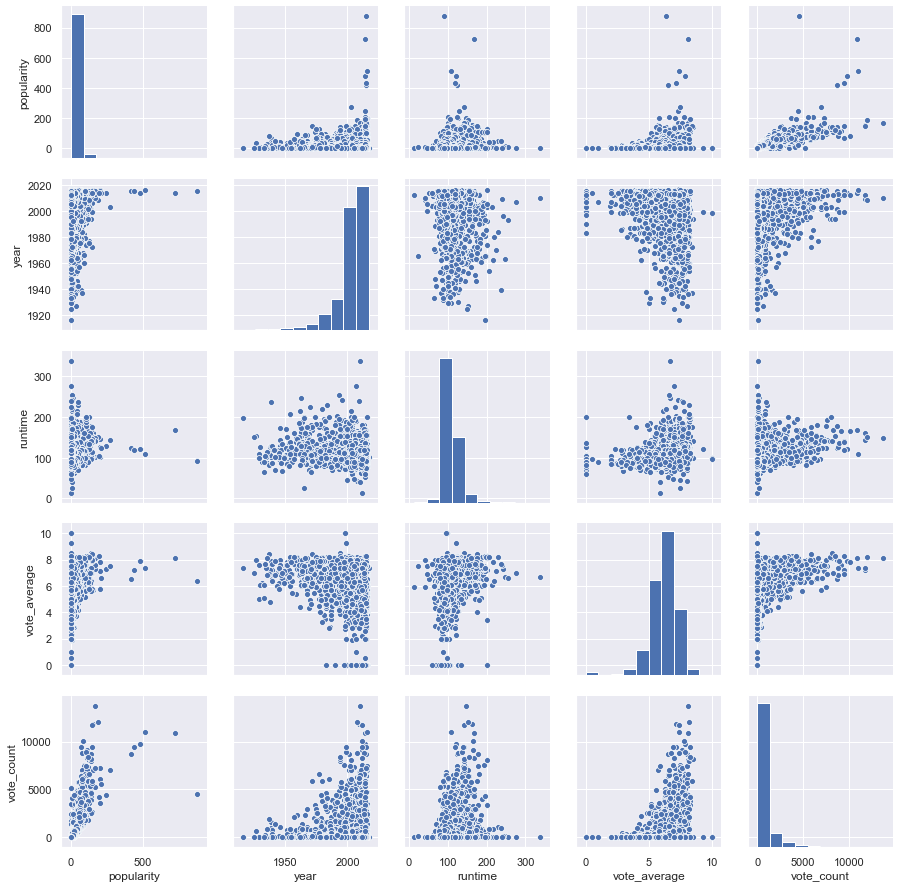

In [33]:
sns.pairplot(movies2)
plt.show()

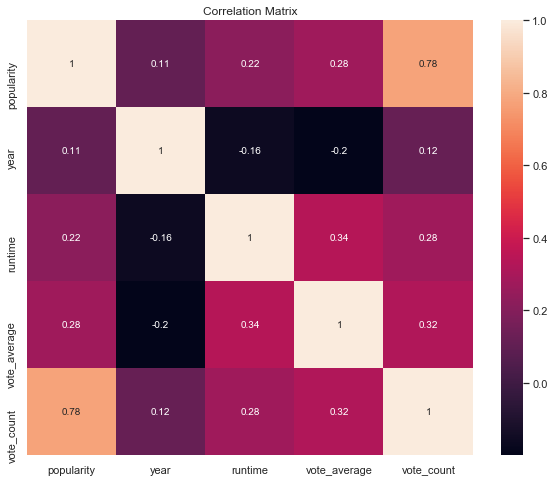

In [339]:
plt.figure(figsize=(10,8))
sns.heatmap(movies2.corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

As we can see from the plots above, except that runtime and vote_average are approximately normal, other variables are skewed. vote_count and popularity are highly correlated (r=0.78).

## Genres

In [26]:
all1 = []
for i in movies2['genres']:
    all1.append(i)
    
all2 = []
for i in all1:
    all2 = all2 + i
    
all_genre = pd.DataFrame(all2, columns=['genre'])

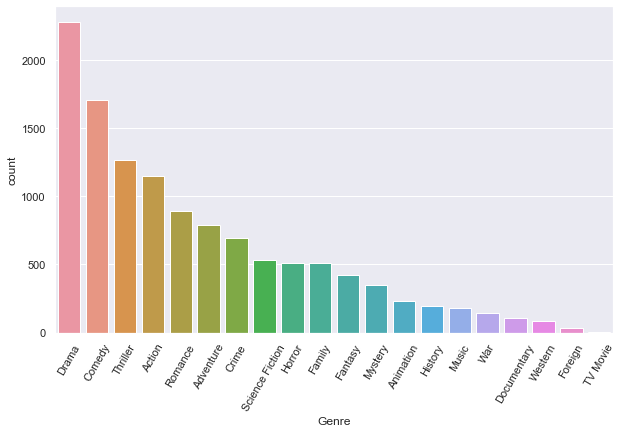

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(all_genre['genre'], order=(all_genre['genre'].value_counts().index))
plt.xlabel('Genre')
plt.xticks(rotation=60)
plt.show()

Most movies are associated with Drama, Comedy, Thriller, Action and Adventure. 

## Keywords

In [28]:
all1 = []
for i in movies2['keywords']:
    all1.append(i)
    
all2 = []
for i in all1:
    all2 = all2 + i

In [29]:
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

all3 = []  
for i in all2:
    if i not in stop_words:
        all3.append(i)

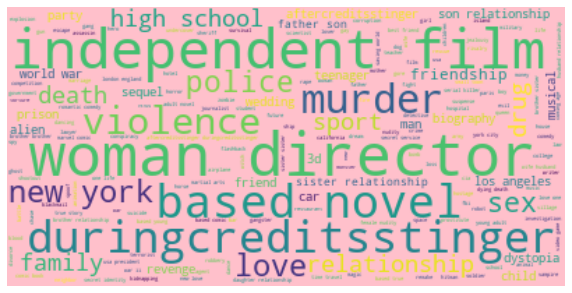

In [30]:
all_keywords = pd.DataFrame(all3, columns=['keyword'])
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="pink").generate(" ".join(all_keywords['keyword']))

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Overview

In [31]:
all1 = []
for i in movies2['overview']:
    all1.append(i.split())
    
all2 = []
for i in all1:
    all2 = all2 + i

In [32]:
all3 = []  
for i in all2:
    if i not in stop_words:
        all3.append(i)

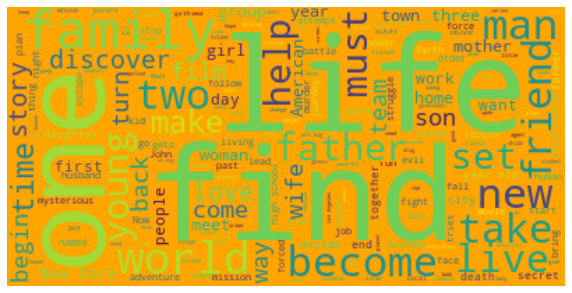

In [33]:
all_words = pd.DataFrame(all3, columns=['word'])
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="orange").generate(" ".join(all_words['word']))

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Cast

In [34]:
all1 = []
for i in movies2['cast']:
    all1.append(i)
    
all2 = []
for i in all1:
    all2 = all2 + i
    
all_cast = pd.DataFrame(all2, columns=['cast'])

In [45]:
print('Top 10 Cast')
all_cast['cast'].value_counts().head(10)

Top 10 Cast


Robert De Niro       41
Bruce Willis         34
Matt Damon           33
Nicolas Cage         32
Denzel Washington    29
Brad Pitt            29
Johnny Depp          29
Eddie Murphy         27
Samuel L. Jackson    27
John Travolta        27
Name: cast, dtype: int64

## Director

In [662]:
print('Top 10 Directors')
movies2['director'].value_counts().head(10)

Top 10 Directors


Steven Spielberg     27
Woody Allen          21
Clint Eastwood       20
Martin Scorsese      19
Ridley Scott         16
Robert Rodriguez     15
Tim Burton           14
Renny Harlin         14
Steven Soderbergh    14
Ron Howard           13
Name: director, dtype: int64

# Feature Engineering 

10 Features include: 

+ Categorical (4): Genres, Keywords, Cast, and Director 
+ Natrual Lauanguage (1): Overview
+ Numeric (5): Popularity, Year, Runtime, Vote Count and Vote Average 

## Genres, Keywords, Cast, Director

+ MultiLabelBinarizer/get_dummies to dummy variables

## Genre

Use multilabelbinarizer to convert genre to dummy variables.

In [35]:
multi_genre = MultiLabelBinarizer()
genres_final = pd.DataFrame(multi_genre.fit_transform(movies2['genres']), index=movies2.index)
genres_final.columns = multi_genre.classes_
genres_final.head()

Action  Adventure  Animation  \
original_title                                                           
Avatar                                         1          1          0   
Pirates of the Caribbean: At World's End       1          1          0   
Spectre                                        1          1          0   
The Dark Knight Rises                          1          0          0   
John Carter                                    1          1          0   

                                          Comedy  Crime  Documentary  Drama  \
original_title                                                                
Avatar                                         0      0            0      0   
Pirates of the Caribbean: At World's End       0      0            0      0   
Spectre                                        0      1            0      0   
The Dark Knight Rises                          0      1            0      1   
John Carter                                    0      0            0      0   

                                          Family  Fantasy  Foreign  History  \
original_title                                                                
Avatar                                         0        1        0        0   
Pirates of the Caribbean: At World's End       0        1        0        0   
Spectre                                        0        0        0        0   
The Dark Knight Rises                          0        0        0        0   
John Carter                                    0        0        0        0   

                                          Horror  Music  Mystery  Romance  \
original_title                                                              
Avatar                                         0      0        0        0   
Pirates of the Caribbean: At World's End       0      0        0        0   
Spectre                                        0      0        0        0   
The Dark Knight Rises                          0      0        0        0   
John Carter                                    0      0        0        0   

                                          Science Fiction  TV Movie  Thriller  \
original_title                                                                  
Avatar                                                  1         0         0   
Pirates of the Caribbean: At World's End                0         0         0   
Spectre                                                 0         0         0   
The Dark Knight Rises                                   0         0         1   
John Carter                                             1         0         0   

                                          War  Western  
original_title                                          
Avatar                                      0        0  
Pirates of the Caribbean: At World's End    0        0  
Spectre                                     0        0  
The Dark Knight Rises                       0        0  
John Carter                                 0        0

## Keywords

Use multilabelbinarizer to convert each key word to a dummy variable.

In [36]:
multi_keywords = MultiLabelBinarizer()
df_keywords = pd.DataFrame(multi_keywords.fit_transform(movies2['keywords']),
                           index=movies2.index)
df_keywords.columns = multi_keywords.classes_
df_keywords.head()

15th century  16th century  \
original_title                                                         
Avatar                                               0             0   
Pirates of the Caribbean: At World's End             0             0   
Spectre                                              0             0   
The Dark Knight Rises                                0             0   
John Carter                                          0             0   

                                          17th century  18th century  1910s  \
original_title                                                                
Avatar                                               0             0      0   
Pirates of the Caribbean: At World's End             0             0      0   
Spectre                                              0             0      0   
The Dark Knight Rises                                0             0      0   
John Carter                                          0             0      0   

                                          1920s  1930s  1940s  1950s  1960s  \
original_title                                                                
Avatar                                        0      0      0      0      0   
Pirates of the Caribbean: At World's End      0      0      0      0      0   
Spectre                                       0      0      0      0      0   
The Dark Knight Rises                         0      0      0      0      0   
John Carter                                   0      0      0      0      0   

                                          1970s  1980s  1990s  19th century  \
original_title                                                                
Avatar                                        0      0      0             0   
Pirates of the Caribbean: At World's End      0      0      0             0   
Spectre                                       0      0      0             0   
The Dark Knight Rises                         0      0      0             0   
John Carter                                   0      0      0             1   

                                          2000 ad  20th century  21st century  \
original_title                                                                  
Avatar                                          0             0             0   
Pirates of the Caribbean: At World's End        0             0             0   
Spectre                                         0             0             0   
The Dark Knight Rises                           0             0             0   
John Carter                                     0             0             0   

                                          25th century  2nd century  3d  \
original_title                                                            
Avatar                                               0            0   1   
Pirates of the Caribbean: At World's End             0            0   0   
Spectre                                              0            0   0   
The Dark Knight Rises                                0            0   0   
John Carter                                          0            0   1   

                                          abandoned house  abandoned mine  \
original_title                                                              
Avatar                                                  0               0   
Pirates of the Caribbean: At World's End                0               0   
Spectre                                                 0               0   
The Dark Knight Rises                                   0               0   
John Carter                                             0               0   

                                          abduction  abolitionist  aboriginal  \
original_title                                                                  
Avatar                                            0             0           0  

## Cast

Use multilabelbinarizer to convert each cast name to a dummy variable.

In [37]:
multi_cast = MultiLabelBinarizer()
df_cast = pd.DataFrame(multi_cast.fit_transform(movies2['cast']),
                       index=movies2.index)
df_cast.columns = multi_cast.classes_
df_cast.head()

"Weird Al" Yankovic  50 Cent  \
original_title                                                           
Avatar                                                      0        0   
Pirates of the Caribbean: At World's End                    0        0   
Spectre                                                     0        0   
The Dark Knight Rises                                       0        0   
John Carter                                                 0        0   

                                          A.J. Buckley  A.J. Cook  \
original_title                                                      
Avatar                                               0          0   
Pirates of the Caribbean: At World's End             0          0   
Spectre                                              0          0   
The Dark Knight Rises                                0          0   
John Carter                                          0          0   

                                          AJ Michalka  Aaliyah  Aamir Khan  \
original_title                                                               
Avatar                                              0        0           0   
Pirates of the Caribbean: At World's End            0        0           0   
Spectre                                             0        0           0   
The Dark Knight Rises                               0        0           0   
John Carter                                         0        0           0   

                                          Aaran Thomas  Aaron Abrams  \
original_title                                                         
Avatar                                               0             0   
Pirates of the Caribbean: At World's End             0             0   
Spectre                                              0             0   
The Dark Knight Rises                                0             0   
John Carter                                          0             0   

                                          Aaron Eckhart  Aaron Kwok  \
original_title                                                        
Avatar                                                0           0   
Pirates of the Caribbean: At World's End              0           0   
Spectre                                               0           0   
The Dark Knight Rises                                 0           0   
John Carter                                           0           0   

                                          Aaron Paul  Aaron Ruell  \
original_title                                                      
Avatar                                             0            0   
Pirates of the Caribbean: At World's End           0            0   
Spectre                                            0            0   
The Dark Knight Rises                              0            0   
John Carter                                        0            0   

                                          Aaron Stanford  \
original_title                                             
Avatar                                                 0   
Pirates of the Caribbean: At World's End               0   
Spectre                                                0   
The Dark Knight Rises                                  0   
John Carter                                            0   

                                          Aaron Taylor-Johnson  \
original_title                                                   
Avatar                                                       0   
Pirates of the Caribbean: At World's End                     0   
Spectre                                                      0   
The Dark Knight Rises                                        0   
John Carter                                                  0   

                                          Aasheekaa Bathija  Abbey Lincoln  \
original_title                             

## Director

Since there is only one director associated with each movie, it is converted to dummy directly.

In [38]:
df_director = pd.DataFrame(movies2['director'], index=movies2.index)

df_director = pd.get_dummies(df_director, drop_first=True)

df_director.head()

director_Aaron Schneider  \
original_title                                                       
Avatar                                                           0   
Pirates of the Caribbean: At World's End                         0   
Spectre                                                          0   
The Dark Knight Rises                                            0   
John Carter                                                      0   

                                          director_Abel Ferrara  \
original_title                                                    
Avatar                                                        0   
Pirates of the Caribbean: At World's End                      0   
Spectre                                                       0   
The Dark Knight Rises                                         0   
John Carter                                                   0   

                                          director_Adam Brooks  \
original_title                                                   
Avatar                                                       0   
Pirates of the Caribbean: At World's End                     0   
Spectre                                                      0   
The Dark Knight Rises                                        0   
John Carter                                                  0   

                                          director_Adam Carolla  \
original_title                                                    
Avatar                                                        0   
Pirates of the Caribbean: At World's End                      0   
Spectre                                                       0   
The Dark Knight Rises                                         0   
John Carter                                                   0   

                                          director_Adam Goldberg  \
original_title                                                     
Avatar                                                         0   
Pirates of the Caribbean: At World's End                       0   
Spectre                                                        0   
The Dark Knight Rises                                          0   
John Carter                                                    0   

                                          director_Adam Green  \
original_title                                                  
Avatar                                                      0   
Pirates of the Caribbean: At World's End                    0   
Spectre                                                     0   
The Dark Knight Rises                                       0   
John Carter                                                 0   

                                          director_Adam Jay Epstein  \
original_title                                                        
Avatar                                                            0   
Pirates of the Caribbean: At World's End                          0   
Spectre                                                           0   
The Dark Knight Rises                                             0   
John Carter                                                       0   

                                          director_Adam Marcus  \
original_title                                                   
Avatar                                                       0   
Pirates of the Caribbean: At World's End                     0   
Spectre                                                      0   
The Dark Knight Rises                                        0   
John Carter                                                  0   

                                          director_Adam McKay  \
original_title                                                  
Avatar                                                      0   
Pirates of the Caribbean: At World's End                   

## Overview 
+ TFIDF

Use TFIDF to process overview text to vectors.

In [39]:
#overview 
movies2['overview'] = movies2['overview'].fillna('')
tfidf = TfidfVectorizer(stop_words='english', min_df=3)
overview = tfidf.fit(movies2['overview'])
df_overview = pd.DataFrame(tfidf.transform(movies2['overview']).todense(), index=movies2.index)
df_overview.columns = tfidf.get_feature_names()
df_overview.head()

00  000  007   10  100  10th   11  \
original_title                                                                 
Avatar                                    0.0  0.0  0.0  0.0  0.0   0.0  0.0   
Pirates of the Caribbean: At World's End  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
Spectre                                   0.0  0.0  0.0  0.0  0.0   0.0  0.0   
The Dark Knight Rises                     0.0  0.0  0.0  0.0  0.0   0.0  0.0   
John Carter                               0.0  0.0  0.0  0.0  0.0   0.0  0.0   

                                          11th   12  12th   13   14   15  150  \
original_title                                                                  
Avatar                                     0.0  0.0   0.0  0.0  0.0  0.0  0.0   
Pirates of the Caribbean: At World's End   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
Spectre                                    0.0  0.0   0.0  0.0  0.0  0.0  0.0   
The Dark Knight Rises                      0.0  0.0   0.0  0.0  0.0  0.0  0.0   
John Carter                                0.0  0.0   0.0  0.0  0.0  0.0  0.0   

                                          15th   16  16th   17  17th   18  \
original_title                                                              
Avatar                                     0.0  0.0   0.0  0.0   0.0  0.0   
Pirates of the Caribbean: At World's End   0.0  0.0   0.0  0.0   0.0  0.0   
Spectre                                    0.0  0.0   0.0  0.0   0.0  0.0   
The Dark Knight Rises                      0.0  0.0   0.0  0.0   0.0  0.0   
John Carter                                0.0  0.0   0.0  0.0   0.0  0.0   

                                          1800  1863  1890  18th   19  1910  \
original_title                                                                
Avatar                                     0.0   0.0   0.0   0.0  0.0   0.0   
Pirates of the Caribbean: At World's End   0.0   0.0   0.0   0.0  0.0   0.0   
Spectre                                    0.0   0.0   0.0   0.0  0.0   0.0   
The Dark Knight Rises                      0.0   0.0   0.0   0.0  0.0   0.0   
John Carter                                0.0   0.0   0.0   0.0  0.0   0.0   

                                          1920  1920s  1927  1930s  1933  \
original_title                                                             
Avatar                                     0.0    0.0   0.0    0.0   0.0   
Pirates of the Caribbean: At World's End   0.0    0.0   0.0    0.0   0.0   
Spectre                                    0.0    0.0   0.0    0.0   0.0   
The Dark Knight Rises                      0.0    0.0   0.0    0.0   0.0   
John Carter                                0.0    0.0   0.0    0.0   0.0   

                                          1937  1939  1940  1940s  1941  1944  \
original_title                                                                  
Avatar                                     0.0   0.0   0.0    0.0   0.0   0.0   
Pirates of the Caribbean: At World's End   0.0   0.0   0.0    0.0   0.0   0.0   
Spectre                                    0.0   0.0   0.0    0.0   0.0   0.0   
The Dark Knight Rises                      0.0   0.0   0.0    0.0   0.0   0.0   
John Carter                                0.0   0.0   0.0    0.0   0.0   0.0   

                                          1945  1947  1949  1950  1950s  1955  \
original_title                                                                  
Avatar                                     0.0   0.0   0.0   0.0    0.0   0.0   
Pirates of the Caribbean: At World's End   0.0   0.0   0.0   0.0    0.0   0.0   
Spectre                                    0.0   0.0   0.0   0.0    0.0   0.0   
The Dark Knight Rises                      0.0   0.0   0.0   0.0    0.0   0.0   
John Carter                                0.0   0.0   0.0   0.0    0.0   0.0   

                                          1959  1960  1960s  1962  1964  1965  \
original_title                                                        

In [53]:
movies3 = pd.DataFrame(movies2[['popularity','year', 'runtime', 'vote_count', 'vote_average']])
movies4 = pd.concat([movies3, genres_final, df_keywords, df_overview, df_cast, df_director], axis=1)
movies4.head()

popularity    year  runtime  \
original_title                                                          
Avatar                                    150.437577  2009.0    162.0   
Pirates of the Caribbean: At World's End  139.082615  2007.0    169.0   
Spectre                                   107.376788  2015.0    148.0   
The Dark Knight Rises                     112.312950  2012.0    165.0   
John Carter                                43.926995  2012.0    132.0   

                                          vote_count  vote_average  Action  \
original_title                                                               
Avatar                                         11800           7.2       1   
Pirates of the Caribbean: At World's End        4500           6.9       1   
Spectre                                         4466           6.3       1   
The Dark Knight Rises                           9106           7.6       1   
John Carter                                     2124           6.1       1   

                                          Adventure  Animation  Comedy  Crime  \
original_title                                                                  
Avatar                                            1          0       0      0   
Pirates of the Caribbean: At World's End          1          0       0      0   
Spectre                                           1          0       0      1   
The Dark Knight Rises                             0          0       0      1   
John Carter                                       1          0       0      0   

                                          Documentary  Drama  Family  Fantasy  \
original_title                                                                  
Avatar                                              0      0       0        1   
Pirates of the Caribbean: At World's End            0      0       0        1   
Spectre                                             0      0       0        0   
The Dark Knight Rises                               0      1       0        0   
John Carter                                         0      0       0        0   

                                          Foreign  History  Horror  Music  \
original_title                                                              
Avatar                                          0        0       0      0   
Pirates of the Caribbean: At World's End        0        0       0      0   
Spectre                                         0        0       0      0   
The Dark Knight Rises                           0        0       0      0   
John Carter                                     0        0       0      0   

                                          Mystery  Romance  Science Fiction  \
original_title                                                                
Avatar                                          0        0                1   
Pirates of the Caribbean: At World's End        0        0                0   
Spectre                                         0        0                0   
The Dark Knight Rises                           0        0                0   
John Carter                                     0        0                1   

                                          TV Movie  Thriller  War  Western  \
original_title                                                               
Avatar                                           0         0    0        0   
Pirates of the Caribbean: At World's End         0         0    0        0   
Spectre                                          0         0    0        0   
The Dark Knight Rises                            0         1    0        0   
John Carter                                      0         0    0        0   

                                          15th century  16th century  \
original_title                                                         
Avatar                                               0        

In [54]:
movies4.shape

(4741, 23504)

## Dimensionality reduction with PCA

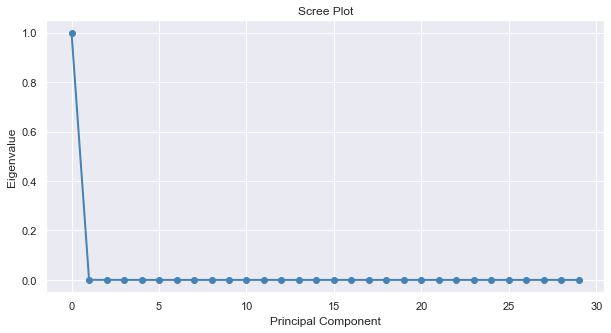

In [56]:
pca = PCA(n_components=30)
pca_components = pca.fit_transform(movies4)

fig = plt.figure(figsize=(10,5))
sing_vals = np.arange(0, pca.n_components_, 1)
eigvals = pca.explained_variance_ratio_
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2, color='steelblue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

As we can see from the scree plot, all variance in the data is explained by the first principle component. Therefore, the first component is kept to represent those 10 features.

In [66]:
pca_movies = pd.DataFrame(pca_components, index=movies4.index)
movies_final = pca_movies.iloc[:,:1]
movies_final.head()

0
original_title                                        
Avatar                                    11101.288442
Pirates of the Caribbean: At World's End   3802.636008
Spectre                                    3767.921205
The Dark Knight Rises                      8407.113084
John Carter                                1425.069833

In [67]:
movies_final.shape

(4741, 1)

# Building Algorithms

According to [Big Five personality traits](https://en.wikipedia.org/wiki/Big_Five_personality_traits), there are five factors about personality which are represented by 'OCEAN'.

+ Openness to experience (inventive/curious vs. consistent/cautious)
+ Conscientiousness (efficient/organized vs. easy-going/careless)
+ Extraversion (outgoing/energetic vs. solitary/reserved)
+ Agreeableness (friendly/compassionate vs. challenging/detached)
+ Neuroticism (sensitive/nervous vs. secure/confident)


Based on this theory, I expect there are no more than 32 types of people in liking movies, when these five factors are fully crossed. Since there are at least 10 genres, I set the lower bound of clusters to be 10. 

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split
import itertools

from numpy.random import seed
seed(1)

In [69]:
#apply scaling
scaler = StandardScaler()
X_std = scaler.fit_transform(movies_final) 

Three clustering algorithms are evaluated and compared based on similarity, consistency and visualization.

## Similarity

### K-Means Clustering

In [70]:
silhouette, ncluster, model = [], [], []

for nclust in range(10,33):
    pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(X_std)
    silh = metrics.silhouette_score(X_std, pred, metric='euclidean')
    
    ncluster.append(nclust)
    silhouette.append(silh)
    model.append('K-Means')

In [71]:
#summarize results
data = {'N_Cluster'   : ncluster,
        'Silhouette'  : silhouette
       }

result_k = pd.DataFrame(data=data, index=model)

result_k =result_k.sort_values(['Silhouette'], ascending=False)

result_k.head()

N_Cluster  Silhouette
K-Means         11    0.628272
K-Means         10    0.627093
K-Means         12    0.614832
K-Means         13    0.614585
K-Means         14    0.613285

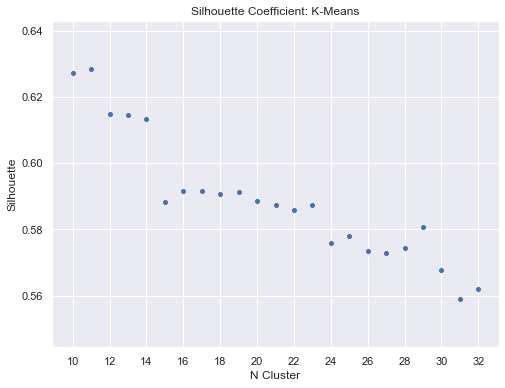

In [72]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='N_Cluster', y='Silhouette', data=result_k)
plt.title('Silhouette Coefficient: K-Means')
plt.xlabel('N Cluster')
plt.xticks(np.arange(10,34,2))
plt.show()

Based on the above plot, the 11-cluster solution produces the highest Silhouette score of 0.63. 

In [73]:
#save results
Ncluster = []
Silhouette = []

Ncluster.append(result_k.iloc[0,0])
Silhouette.append(round(result_k.iloc[0,1],2))

### Hierarchical Clustering

In [74]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools

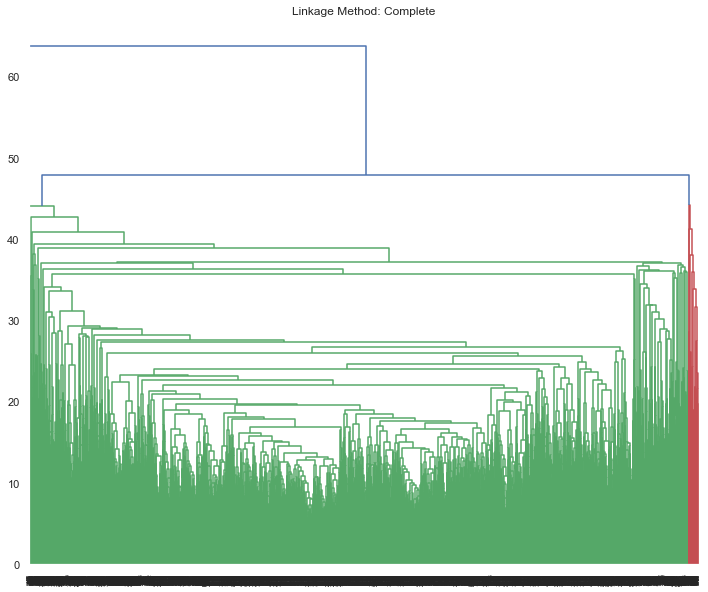

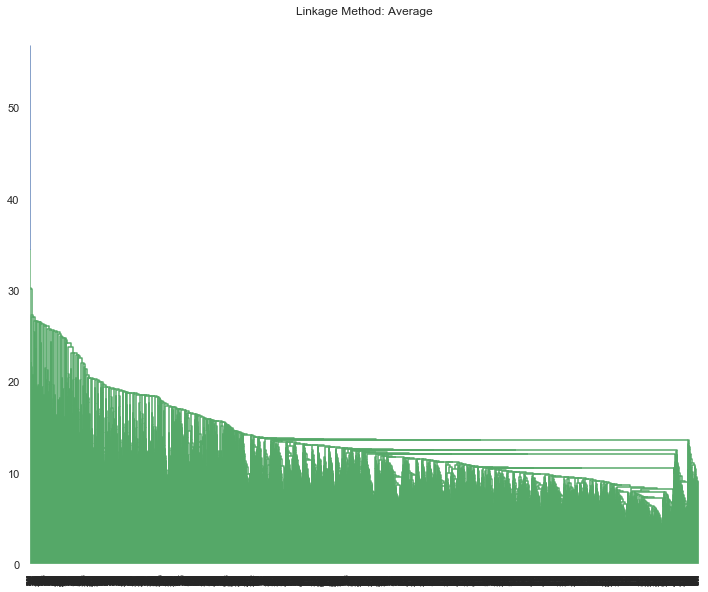

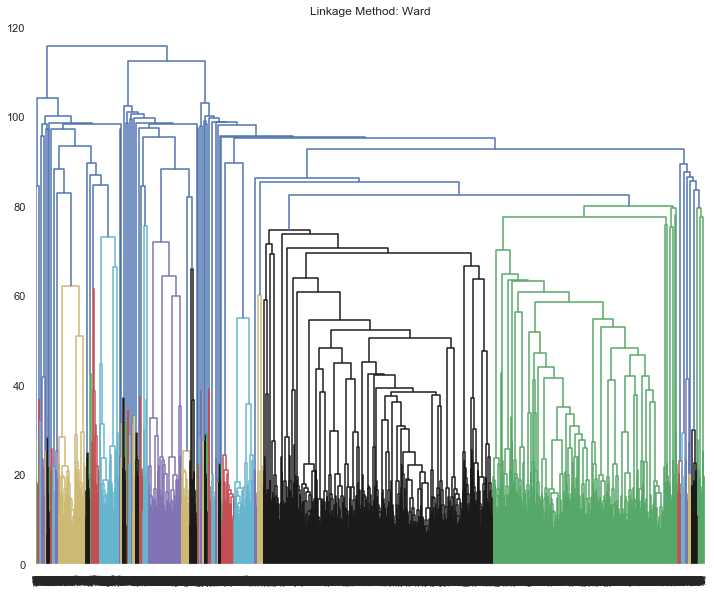

In [341]:
methods = ['complete', 'average', 'ward']
for method in methods:
    plt.figure(figsize=(12,10)) 
    dendrogram(linkage(X_std, method=method))
    plt.title('Linkage Method: {}'.format(method.capitalize()))
    plt.show()

Above dendrograms indicate that Ward produces most reasonable resutls among three linkage methods.

In [75]:
silhouette, ncluster, model = [], [], []

for nclust in range(10,33):
    
    agg = AgglomerativeClustering(linkage='ward', 
                                  affinity='euclidean',
                                  n_clusters=nclust)

    y_pred = agg.fit_predict(X_std)
    
    silh = metrics.silhouette_score(X_std, y_pred, metric='euclidean')
    
    ncluster.append(nclust)
    silhouette.append(silh)
    model.append('Hierarchical')

In [76]:
#summarize results
data = {'N_Cluster'   : ncluster,
        'Silhouette'  : silhouette,
       }

result_h = pd.DataFrame(data=data, index=model)

result_h = result_h.sort_values(['Silhouette'], ascending=False)

result_h.head()

N_Cluster  Silhouette
Hierarchical         15    0.578433
Hierarchical         14    0.573345
Hierarchical         12    0.571833
Hierarchical         11    0.571566
Hierarchical         13    0.570399

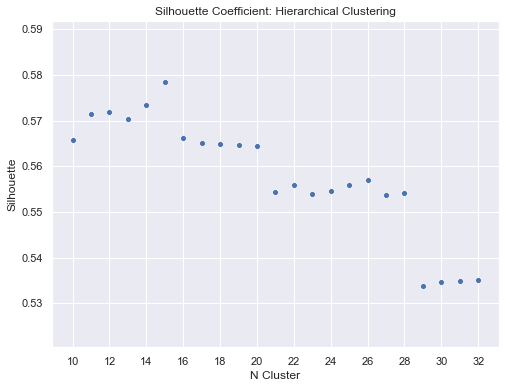

In [77]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='N_Cluster', y='Silhouette', data=result_h)
plt.title('Silhouette Coefficient: Hierarchical Clustering')
plt.xlabel('N Cluster')
plt.xticks(np.arange(10,34,2))
plt.show()

Based on the above plot, the 15-cluster solution produces the high Silhouette score of 0.58.

In [78]:
Ncluster.append(result_h.iloc[0,0])
Silhouette.append(round(result_h.iloc[0,1],2))

### GMM

In [79]:
from sklearn.mixture import GaussianMixture
import itertools

In [80]:
covs = ['full', 'tied', 'diag', 'spherical']

n_cluster_values = range(10,33)

covariance, silhouette, n_clusters = [], [], []

for cov_type, n_cluster in itertools.product(covs, n_cluster_values):
    
    gmm_cluster = GaussianMixture(n_components=n_cluster, 
                                  random_state=123, 
                                  covariance_type=cov_type)

    y_pred = gmm_cluster.fit_predict(X_std)

    silh = metrics.silhouette_score(X_std, y_pred, metric='euclidean')
    
    silhouette.append(silh)
    covariance.append(cov_type)
    n_clusters.append(n_cluster)

In [81]:
data = {'N_Cluster'        : n_clusters, 
        'Covariance Type'  : covariance,
        'Silhouette'       : silhouette 
       }

result_g = pd.DataFrame(data=data)

result_g = result_g.sort_values(['Silhouette'], ascending=False)

result_g.head()

N_Cluster Covariance Type  Silhouette
23         10            tied    0.650960
25         12            tied    0.616191
30         17            tied    0.609464
31         18            tied    0.607164
29         16            tied    0.604714

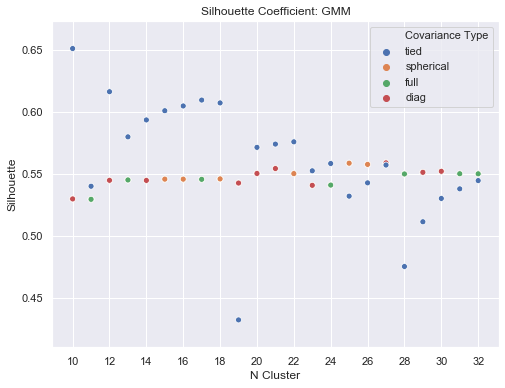

In [82]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='N_Cluster', y='Silhouette', hue='Covariance Type', data=result_g)
plt.title('Silhouette Coefficient: GMM')
plt.xlabel('N Cluster')
plt.xticks(np.arange(10,34,2))
plt.show()

Results of GMM show that the tired covariance works the best among four covariance types. 10-cluster solution produces the highest Silhouette score of 0.65. 

In [83]:
Ncluster.append(result_g.iloc[0,0])
Silhouette.append(round(result_g.iloc[0,2],2))

## Consistency

To assess consistency of clustering, I followed the steps:

1. Randomly select 25% movies from the final dataset 
2. Split the rest of movies (75%) into two halves 
3. Put those 25% movies into both samples 
4. Evaluate consistency of clustering for those common movies 

In [84]:
#randomly select 25% movies as common
common = pd.DataFrame(movies2.sample(n=1185))
common = common.drop(['keywords', 'overview'], axis=1)
common['common'] = 1

print('Randomly selected {} (25%) movies as common.'.format(common.shape[0]))

common_movies = []

#flag commom movies in the dataset 
for i in movies_final.index:
    if i in common.index:
        common_movies.append(1)
    else:
        common_movies.append(0)
        
movies_final['common'] = common_movies

movies_75p = movies_final[movies_final['common']==0]
movies_25p = movies_final[movies_final['common']==1]
      

#prepare data for consistency eval
train, test = train_test_split(movies_75p, test_size=0.5)

#print(train.shape, test.shape)

#add common movies to each sample
X_train = pd.concat([train, movies_25p], axis=0)
print(X_train['common'].value_counts())
X_train = X_train.drop(['common'], axis=1)
print('X_train shape: {}.'.format(X_train.shape))

X_test = pd.concat([test, movies_25p], axis=0)
print(X_test['common'].value_counts())
X_test = X_test.drop(['common'], axis=1)
print('X_test shape: {}.'.format(X_test.shape))

#apply scaling to train and test 
scaler = StandardScaler()
X1 = scaler.fit_transform(X_train)
X2 = scaler.fit_transform(X_test)

#prep commom movies to merge with clustering file
common0 = common.reset_index()
common0 = common0.set_index(np.arange(len(common)))

Randomly selected 1185 (25%) movies as common.
0    1777
1    1187
Name: common, dtype: int64
X_train shape: (2964, 1).
0    1777
1    1187
Name: common, dtype: int64
X_test shape: (2964, 1).


In [85]:
#run k-means with two samples previously selected solution
ypred = pd.DataFrame()
nclusts = [11]

for nclust in nclusts:
    pred1 = KMeans(n_clusters=nclust, random_state=123).fit_predict(X1)
    pred2 = KMeans(n_clusters=nclust, random_state=123).fit_predict(X2)
    ypred['kclust' + str(nclust) + '_sample0'] = pred1
    ypred['kclust' + str(nclust) + '_sample1'] = pred2

In [86]:
#run hierarchical with two samples previously selected solution

nclusts = [15]

for nclust in nclusts:    
    agg = AgglomerativeClustering(linkage='ward', 
                                  affinity='euclidean',
                                  n_clusters=nclust)

    pred1 = agg.fit_predict(X1)
    pred2 = agg.fit_predict(X2)
    
    ypred['hclust' + str(nclust) + '_sample0'] = pred1
    ypred['hclust' + str(nclust) + '_sample1'] = pred2

In [87]:
#run GMM with two samples previously selected solution
nclusts = [10]

for nclust in nclusts: 
    gmm_cluster = GaussianMixture(n_components=nclust, 
                                  random_state=123, 
                                  covariance_type='tied')

    pred1 = gmm_cluster.fit_predict(X1)
    pred2 = gmm_cluster.fit_predict(X2)
    
    ypred['gclust' + str(nclust) + '_sample0'] = pred1
    ypred['gclust' + str(nclust) + '_sample1'] = pred2

Check clustering consistency of those 1185 common items.

In [88]:
ypred.set_index(np.arange(len(ypred)))

clusters_common = pd.merge(common0, ypred, left_index=True, right_index=True)

clusters_common.shape

(1185, 16)

In [89]:
clusters_common.head()

original_title                        genres  popularity  \
0                   Three to Tango             [Comedy, Romance]    7.553773   
1                      The Canyons             [Thriller, Drama]    6.978907   
2       The Indian in the Cupboard  [Adventure, Family, Fantasy]   11.095914   
3  Barbershop 2:  Back in Business               [Comedy, Drama]    6.501815   
4                 Basic Instinct 2    [Crime, Mystery, Thriller]   13.483387   

     year  runtime  vote_average  vote_count  \
0  1999.0     98.0           5.4          62   
1  2013.0     99.0           4.1          75   
2  1995.0     96.0           5.9         134   
3  2004.0    106.0           5.6          74   
4  2006.0    114.0           4.6         180   

                                 cast               director  common  \
0      [Matthew Perry, Neve Campbell]     Damon Santostefano       1   
1         [Lindsay Lohan, James Deen]          Paul Schrader       1   
2            [Hal Scardino, Litefoot]               Frank Oz       1   
3  [Ice Cube, Cedric the Entertainer]  Kevin Rodney Sullivan       1   
4     [Sharon Stone, David Morrissey]    Michael Caton-Jones       1   

   kclust11_sample0  kclust11_sample1  hclust15_sample0  hclust15_sample1  \
0                 1                 3                11                 0   
1                 6                 0                 2                 2   
2                 4                 3                 8                 0   
3                 6                10                 2                10   
4                 1                 3                 9                 0   

   gclust10_sample0  gclust10_sample1  
0                 1                 2  
1                 1                 2  
2                 4                 2  
3                 1                 2  
4                 1                 2

In [90]:
print(len(clusters_common['kclust11_sample0'].value_counts()))
print(len(clusters_common['gclust10_sample0'].value_counts()))
print(len(clusters_common['hclust15_sample0'].value_counts()))
print(' ')
print(len(clusters_common['kclust11_sample1'].value_counts()))
print(len(clusters_common['gclust10_sample1'].value_counts()))
print(len(clusters_common['hclust15_sample1'].value_counts()))

#number of clusters contain any of those 25% common movies 

11
10
15
 
11
9
15


In [92]:
#check k-means 11-cluster solution 
kmeans11 = pd.DataFrame(clusters_common[['original_title', 'kclust11_sample0', 'kclust11_sample1']])

kmeans11a = kmeans11.groupby(['kclust11_sample0']).indices
kmeans11b = kmeans11.groupby(['kclust11_sample1']).indices

In [95]:
kinda = []
kindb = []
kout = []

#calcuate intersection over union rate
def iou(l1, l2):
    l3 = list(set(l1) & set(l2))
    l4 = list(set(l1) | set(l2))
    ratio = len(l3)/len(l4)
    return ratio

ka = range(0,10)
kb = range(0,10)

for i, j in itertools.product(ka,kb):
    kinda.append(i)
    kindb.append(j)
    kout.append(iou(kmeans11a[i], kmeans11b[j]))

In [96]:
data = {'kmeans11a'    : kinda,
        'kmeans11b'    : kindb, 
        'IOU' : kout}

kresults = pd.DataFrame(data=data)

In [97]:
kresults = kresults.sort_values(['IOU'], ascending=False)
kresults.head()

kmeans11a  kmeans11b       IOU
14          1          3  0.286223
21          1         10  0.179487
69          6          3  0.171642
76          6         10  0.127660
11          1          0  0.106222

In [98]:
#get pairs with max IOU
df = kresults.copy()
pairs = []
iou = []
for i, row in df.iterrows():
    a = row['kmeans11a']
    b = row['kmeans11b']
    if a in ka and b in kb:
        pairs.append((a,b))
        iou.append(row['IOU'])
        ka.remove(a)
        kb.remove(b)

In [99]:
data = {'Pairs':pairs,
        'IOU'  :iou}

iouk = pd.DataFrame(data=data)

Avg_IOU = []
Avg_IOU.append(round(iouk['IOU'].mean(),2))

In [101]:
#check hierarchical 15-cluster solution 
hier15 = pd.DataFrame(clusters_common[['original_title', 'hclust15_sample0', 'hclust15_sample1']])

In [102]:
hier15a = hier15.groupby(['hclust15_sample0']).indices
hier15b = hier15.groupby(['hclust15_sample1']).indices

In [116]:
hinda = []
hindb = []
hout = []

#calcuate intersection over union rate
def iou(l1, l2):
    l3 = list(set(l1) & set(l2))
    l4 = list(set(l1) | set(l2))
    ratio = len(l3)/len(l4)
    return ratio

ha = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
hb = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

for i, j in itertools.product(ha,hb):
    hinda.append(i)
    hindb.append(j)
    hout.append(iou(hier15a[i],hier15b[j]))

In [117]:
data = {'hier15a'    : hinda,
        'hier15b'    : hindb, 
        'IOU'        : hout}

hresults = pd.DataFrame(data=data)

In [118]:
hresults = hresults.sort_values(['IOU'], ascending=False)
hresults.head()

hier15a  hier15b       IOU
165       11        0  0.253788
135        9        0  0.185079
175       11       10  0.129524
30         2        0  0.116959
167       11        2  0.108779

In [119]:
#get pairs with max IOU
df = hresults.copy()
pairs = []
iou = []
for i, row in df.iterrows():
    a = row['hier15a']
    b = row['hier15b']
    if a in ha and b in hb:
        pairs.append((a,b))
        iou.append(row['IOU'])
        ha.remove(a)
        hb.remove(b)

In [120]:
data = {'Pairs':pairs,
        'IOU'  :iou}

iouh = pd.DataFrame(data=data)

Avg_IOU.append(round(iouh['IOU'].mean(),2))

In [122]:
#check GMM 10-cluster solution 
gmm10 = pd.DataFrame(clusters_common[['original_title', 'gclust10_sample0', 'gclust10_sample1']])

gmm10a = gmm10.groupby(['gclust10_sample0']).indices
gmm10b = gmm10.groupby(['gclust10_sample1']).indices

In [126]:
ginda = []
gindb = []
gout = []

#calcuate intersection over union rate
def iou(l1, l2):
    l3 = list(set(l1) & set(l2))
    l4 = list(set(l1) | set(l2))
    ratio = len(l3)/len(l4)
    return ratio

ga = [0,1,2,3,4,5,6,7,8,9]
gb = [0,1,2,3,4,5,6,7,9]

for i, j in itertools.product(ga,gb):
    ginda.append(i)
    gindb.append(j)
    gout.append(iou(gmm10a[i], gmm10b[j]))

In [127]:
data = {'gmm10a'    : ginda,
        'gmm10b'    : gindb, 
        'IOU'       : gout}

gresults = pd.DataFrame(data=data)

In [128]:
gresults = gresults.sort_values(['IOU'], ascending=False)
gresults.head()

gmm10a  gmm10b       IOU
11       1       2  0.533883
9        1       0  0.128234
2        0       2  0.119678
0        0       0  0.063604
17       1       9  0.063146

In [129]:
#get cluster pairs with max IOU
df = gresults.copy()
pairs = []
iou = []
for i, row in df.iterrows():
    a = row['gmm10a']
    b = row['gmm10b']
    if a in ga and b in gb:
        pairs.append((a,b))
        iou.append(row['IOU'])
        ga.remove(a)
        gb.remove(b)

In [130]:
data = {'Pairs':pairs,
        'IOU'  :iou}

ioug = pd.DataFrame(data=data)

Avg_IOU.append(round(ioug['IOU'].mean(),2))

In [131]:
#summarize results 
Algorithm = ['K-Means', 'Hierarchical', 'GMM']

data = {'N_Cluster'  : Ncluster,
        'Silhouette' : Silhouette,
        'Avg_IOU'    : Avg_IOU}

summary = pd.DataFrame(data=data, index=Algorithm)
summary

N_Cluster  Silhouette  Avg_IOU
K-Means            11.0        0.63     0.05
Hierarchical       15.0        0.58     0.05
GMM                10.0        0.65     0.08

## Visualization of Clustering

### Dimensionality Reduction Methods 
+ PCA
+ T-SNE
+ UMAP

In [132]:
#apply scaling
scaler = StandardScaler()
X_std = scaler.fit_transform(movies_final)

In [133]:
ypred = pd.DataFrame()

#k-means 11-cluster solution

nclusts = [11]

for nclust in nclusts:
    pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(X_std)
    ypred['kclust' + str(nclust)] = pred

In [134]:
#hierarchical 15-cluster solution 

nclusts = [15]

for nclust in nclusts:    
    agg = AgglomerativeClustering(linkage='ward', 
                                  affinity='euclidean',
                                  n_clusters=nclust)
    pred = agg.fit_predict(X_std)
    
    ypred['hclust' + str(nclust)] = pred

In [135]:
#GMM 10-cluster solution

nclusts = [10]

for nclust in nclusts: 
    gmm_cluster = GaussianMixture(n_components=nclust, 
                                  random_state=123, 
                                  covariance_type='tied')

    pred = gmm_cluster.fit_predict(X_std)
    
    ypred['gclust' + str(nclust)] = pred

In [136]:
#PCA
pca = PCA(n_components=2)

pca = pca.fit_transform(X_std)

ypred['pca1'] = pca[:, 0]
ypred['pca2'] = pca[:, 1]

#T-SNE
tsne = TSNE(n_components=2)

tsne = tsne.fit_transform(X_std)

ypred['tsne1'] = tsne[:, 0]
ypred['tsne2'] = tsne[:, 1]

#UMAP
umap = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.3, metric='correlation')

umap = umap.fit_transform(X_std)

ypred['umap1'] = umap[:, 0]
ypred['umap2'] = umap[:, 1]

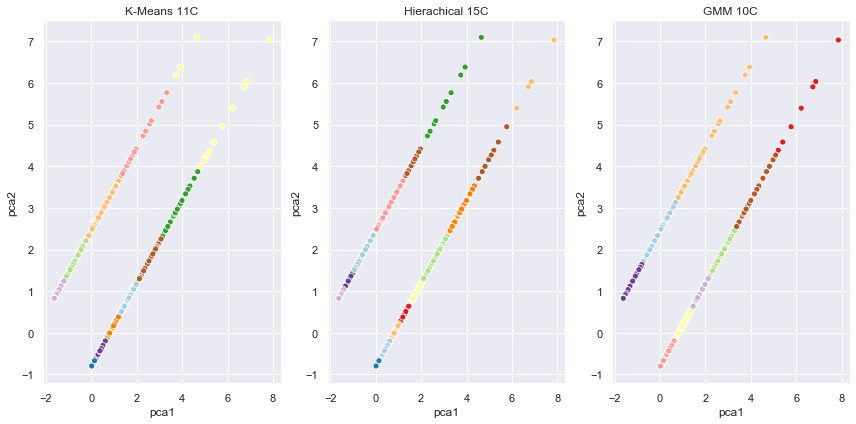

In [137]:
plt.figure(figsize=(12,6))
plt.subplot(131)
sns.scatterplot(x='pca1', y='pca2', hue='kclust11', data=ypred, palette='Paired', legend=False)
plt.title('K-Means 11C')
plt.subplot(132)
sns.scatterplot(x='pca1', y='pca2', hue='hclust15', data=ypred, palette='Paired', legend=False)
plt.title('Hierachical 15C')
plt.subplot(133)
sns.scatterplot(x='pca1', y='pca2', hue='gclust10', data=ypred, palette='Paired', legend=False)
plt.title('GMM 10C')
plt.tight_layout()
plt.show()

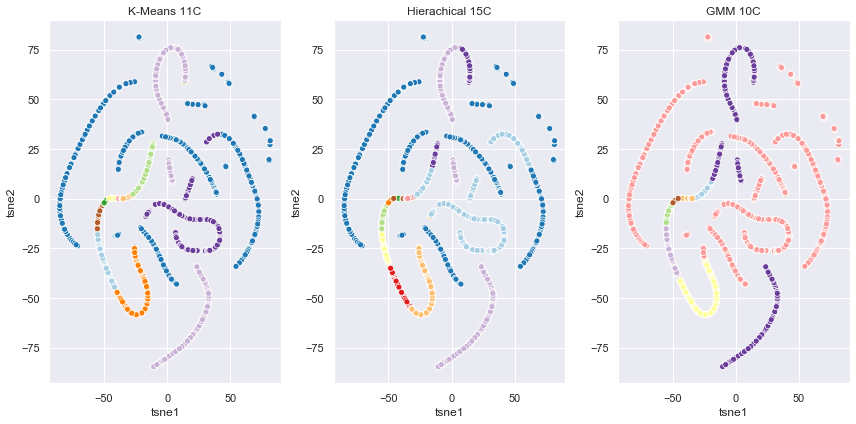

In [138]:
plt.figure(figsize=(12,6))
plt.subplot(131)
sns.scatterplot(x='tsne1', y='tsne2', hue='kclust11', data=ypred, palette='Paired', legend=False)
plt.title('K-Means 11C')
plt.subplot(132)
sns.scatterplot(x='tsne1', y='tsne2', hue='hclust15', data=ypred, palette='Paired', legend=False)
plt.title('Hierachical 15C')
plt.subplot(133)
sns.scatterplot(x='tsne1', y='tsne2', hue='gclust10', data=ypred, palette='Paired', legend=False)
plt.title('GMM 10C')
plt.tight_layout()
plt.show()

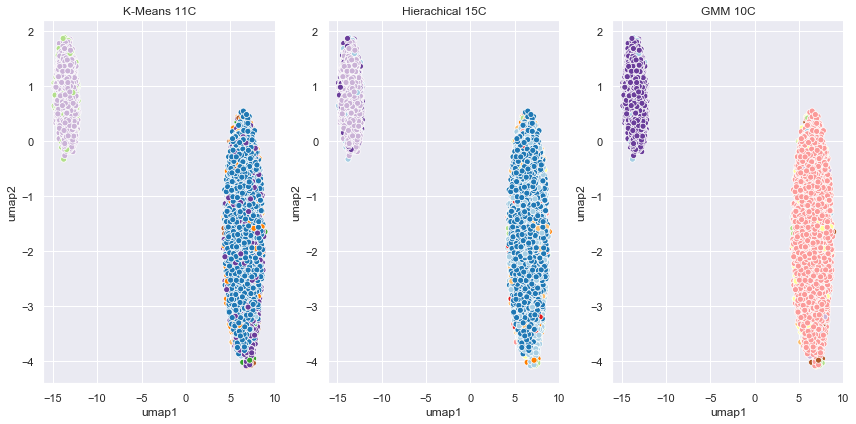

In [139]:
plt.figure(figsize=(12,6))
plt.subplot(131)
sns.scatterplot(x='umap1', y='umap2', hue='kclust11', data=ypred, palette='Paired', legend=False)
plt.title('K-Means 11C')
plt.subplot(132)
sns.scatterplot(x='umap1', y='umap2', hue='hclust15', data=ypred, palette='Paired', legend=False)
plt.title('Hierachical 15C')
plt.subplot(133)
sns.scatterplot(x='umap1', y='umap2', hue='gclust10', data=ypred, palette='Paired', legend=False)
plt.title('GMM 10C')
plt.tight_layout()
plt.show()

In evaluating overall performance of clustering algorithms, I decide to go with the GMM 10-cluster solution. 

# Recommendation Engine

The recommendation engine is created based on the GMM 10-cluster solution. However, there are actually 9 clusters presented in this solution. 

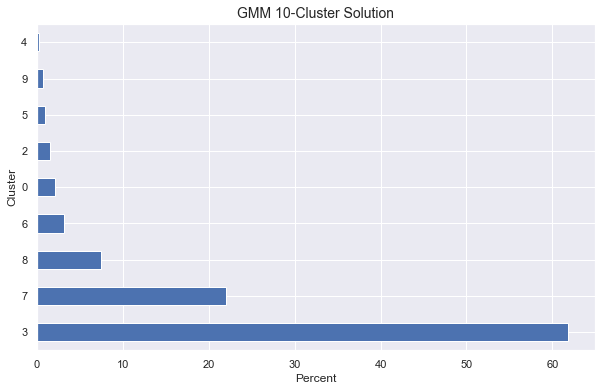

In [160]:
cluster = (ypred['gclust10'].value_counts(normalize=True).rename('Percent').mul(100))
plt.figure(figsize=(10,6))
cluster.plot(kind='barh')
plt.xlabel('Percent')
plt.ylabel('Cluster')
plt.title('GMM 10-Cluster Solution', fontsize=14)
plt.show()

In [169]:
#merge cluster assignment to dataset
movies5 = sm2.reset_index()
pred = pd.DataFrame(ypred['gclust10'])
pred['Cluster'] = pred['gclust10']
pred = pred.drop(['gclust10'],axis=1)

In [170]:
movies5.set_index(np.arange(len(movies5)))
pred.set_index(np.arange(len(pred)))

movies_cluster = pd.merge(movies5, pred, left_index=True, right_index=True)

movies_cluster.head()

original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                          genres  popularity    year  runtime  \
0  [Action, Adventure, Fantasy, Science Fiction]  150.437577  2009.0    162.0   
1                   [Adventure, Fantasy, Action]  139.082615  2007.0    169.0   
2                     [Action, Adventure, Crime]  107.376788  2015.0    148.0   
3               [Action, Crime, Drama, Thriller]  112.312950  2012.0    165.0   
4           [Action, Adventure, Science Fiction]   43.926995  2012.0    132.0   

   vote_average  vote_count                             cast  \
0           7.2       11800   [Sam Worthington, Zoe Saldana]   
1           6.9        4500     [Johnny Depp, Orlando Bloom]   
2           6.3        4466  [Daniel Craig, Christoph Waltz]   
3           7.6        9106  [Christian Bale, Michael Caine]   
4           6.1        2124    [Taylor Kitsch, Lynn Collins]   

            director  Cluster  
0      James Cameron        4  
1     Gore Verbinski        5  
2         Sam Mendes        2  
3  Christopher Nolan        4  
4     Andrew Stanton        8

In [180]:
#function for identifying similar movies 

def find_similar_movies(name):
    
    cluster = movies_cluster[movies_cluster['original_title']==name]['Cluster'].values
    
    out = movies_cluster[movies_cluster['Cluster']==cluster[0]]
    
    out = out.sort_values(['popularity'], ascending=False)
    
    similar = out[out['original_title']!=name].sort_values(['popularity'], ascending=False)
    
    target = out[out['original_title']==name]
    
    others = out.shape[0]-1
    
    if others>10:
    
        print('There are {} movies you might like. Here are the Top 10.'.format(others))
    
    else:
        print('There are {} movies you might like. Here are the Top {}.'.format(others, others))
    
    out = pd.concat([target, similar], axis=0)
    
    out.index = pd.RangeIndex(len(out.index))

    return out.head(11)

In [183]:
find_similar_movies('Inception')

There are 8 movies you might like. Here are the Top 8.


original_title  \
0              Inception   
1           Interstellar   
2     Mad Max: Fury Road   
3        The Dark Knight   
4                 Avatar   
5           The Avengers   
6  The Dark Knight Rises   
7       Django Unchained   
8       The Hunger Games   

                                                    genres  popularity  \
0  [Action, Thriller, Science Fiction, Mystery, Adventure]  167.583710   
1                      [Adventure, Drama, Science Fiction]  724.247784   
2           [Action, Adventure, Science Fiction, Thriller]  434.278564   
3                         [Drama, Action, Crime, Thriller]  187.322927   
4            [Action, Adventure, Fantasy, Science Fiction]  150.437577   
5                     [Science Fiction, Action, Adventure]  144.448633   
6                         [Action, Crime, Drama, Thriller]  112.312950   
7                                         [Drama, Western]   82.121691   
8                    [Science Fiction, Adventure, Fantasy]   68.550698   

     year  runtime  vote_average  vote_count  \
0  2010.0    148.0           8.1       13752   
1  2014.0    169.0           8.1       10867   
2  2015.0    120.0           7.2        9427   
3  2008.0    152.0           8.2       12002   
4  2009.0    162.0           7.2       11800   
5  2012.0    143.0           7.4       11776   
6  2012.0    165.0           7.6        9106   
7  2012.0    165.0           7.8       10099   
8  2012.0    142.0           6.9        9455   

                                        cast           director  Cluster  
0  [Leonardo DiCaprio, Joseph Gordon-Levitt]  Christopher Nolan        4  
1    [Matthew McConaughey, Jessica Chastain]  Christopher Nolan        4  
2               [Tom Hardy, Charlize Theron]      George Miller        4  
3             [Christian Bale, Heath Ledger]  Christopher Nolan        4  
4             [Sam Worthington, Zoe Saldana]      James Cameron        4  
5           [Robert Downey Jr., Chris Evans]        Joss Whedon        4  
6            [Christian Bale, Michael Caine]  Christopher Nolan        4  
7              [Jamie Foxx, Christoph Waltz]  Quentin Tarantino        4  
8       [Jennifer Lawrence, Josh Hutcherson]          Gary Ross        4

In [184]:
find_similar_movies('Titanic')

There are 35 movies you might like. Here are the Top 10.


original_title  \
0                                                  Titanic   
1   Pirates of the Caribbean: The Curse of the Black Pearl   
2                                               Big Hero 6   
3                               Captain America: Civil War   
4                                              The Martian   
5                       Batman v Superman: Dawn of Justice   
6                                            The Godfather   
7                                                Gone Girl   
8                                             Forrest Gump   
9        The Lord of the Rings: The Fellowship of the Ring   
10                                The Shawshank Redemption   

                                            genres  popularity    year  \
0                       [Drama, Romance, Thriller]  100.025899  1997.0   
1                     [Adventure, Fantasy, Action]  271.972889  2003.0   
2   [Adventure, Family, Animation, Action, Comedy]  203.734590  2014.0   
3             [Adventure, Action, Science Fiction]  198.372395  2016.0   
4              [Drama, Adventure, Science Fiction]  167.932870  2015.0   
5                     [Action, Adventure, Fantasy]  155.790452  2016.0   
6                                   [Drama, Crime]  143.659698  1972.0   
7                       [Mystery, Thriller, Drama]  143.041543  2014.0   
8                         [Comedy, Drama, Romance]  138.133331  1994.0   
9                     [Adventure, Fantasy, Action]  138.049577  2001.0   
10                                  [Drama, Crime]  136.747729  1994.0   

    runtime  vote_average  vote_count                               cast  \
0     194.0           7.5        7562  [Kate Winslet, Leonardo DiCaprio]   
1     143.0           7.5        6985       [Johnny Depp, Geoffrey Rush]   
2     102.0           7.8        6135         [Scott Adsit, Ryan Potter]   
3     147.0           7.1        7241   [Chris Evans, Robert Downey Jr.]   
4     141.0           7.6        7268     [Matt Damon, Jessica Chastain]   
5     151.0           5.7        7004        [Ben Affleck, Henry Cavill]   
6     175.0           8.4        5893         [Marlon Brando, Al Pacino]   
7     145.0           7.9        5862       [Ben Affleck, Rosamund Pike]   
8     142.0           8.2        7927          [Tom Hanks, Robin Wright]   
9     178.0           8.0        8705        [Elijah Wood, Ian McKellen]   
10    142.0           8.5        8205      [Tim Robbins, Morgan Freeman]   

                director  Cluster  
0          James Cameron        9  
1         Gore Verbinski        9  
2         Chris Williams        9  
3          Anthony Russo        9  
4           Ridley Scott        9  
5            Zack Snyder        9  
6   Francis Ford Coppola        9  
7          David Fincher        9  
8        Robert Zemeckis        9  
9          Peter Jackson        9  
10        Frank Darabont        9

# Summary

+ Used multiple clustering algorithms to unpack the underlying pattern of movie data
+ Grouped 4K+ movies into 10-15 clusters based on their characteristics
+ Evaluated performance of algorithms from various perspectives
+ Built a recommendation engine based on the GMM solution

# Future Work

+ Incorperate individual user rating data and build collaborative filtering system
+ Make the engine more powerful not only considering movie characteristics but also user opinions